# Assignment 5

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response questions, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.



### Problem 1: Poisson Data

In the last assignment, we modeled a vector of counts $y = (y_1, \ldots, y_n)$ using a multinomial distribution. 

Unlike last time, all of these counts will now assumed to be independent. Further, we can't reasonably put a bound on what each count could be. So, in this problem, we'll use a **Poisson likelihood**:

$$
L(y \mid \theta) = \prod_{i=1}^n L(y_i \mid \theta) \propto \prod_{i=1}^n e^{-\theta}\theta^{y_i} = e^{-n\theta}\theta^{\sum_i y_i}
$$

With this likelihood, $\theta > 0$ is interpreted as a rate or average.

The data can be found in `Road_Casualties_in_Great_Britain_1969___84_434_19.csv` Use the `DriversKilled` column only.

In [1]:
import pandas as pd
import numpy as np

dk = np.array(pd.read_csv('Road_Casualties_in_Great_Britain_1969___84_434_19.csv').DriversKilled)

1.

Name a conjugate prior for this likelihood! Write your single-word answer in Gradescope.

2.

Suppose that the previous answer does not suite your needs, and that you want to use a lognormal prior! Pick a specific prior distribution (i.e. specify the hyperparameters), and describe a rationale as to why you chose them. 



In [2]:
dk.mean()

122.80208333333333

3.

Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - report estimates of the mean, 5th and 95th percentiles of this posterior
 - comment on whether your posterior mean is close to the frequentist estimator of $\theta$ (which is the sample mean of your data)


In [3]:
import os
from cmdstanpy import CmdStanModel

# bulid model
model_code = os.path.join('.', 'poisson_log_norm.stan')
model = CmdStanModel(stan_file=model_code)

01:01:46 - cmdstanpy - INFO - compiling stan file /bml24/05/poisson_log_norm.stan to exe file /bml24/05/poisson_log_norm
01:02:05 - cmdstanpy - INFO - compiled model executable: /bml24/05/poisson_log_norm


In [4]:
model

CmdStanModel: name=poisson_log_norm
	 stan_file=/bml24/05/poisson_log_norm.stan
	 exe_file=/bml24/05/poisson_log_norm
	 compiler_options=stanc_options={}, cpp_options={}

In [5]:
# sample from model
num_samps = 192
normal_data = {'N' : num_samps, 'y': dk}
fit = model.sample(normal_data)

01:02:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:02:05 - cmdstanpy - INFO - CmdStan done processing.


1.00117

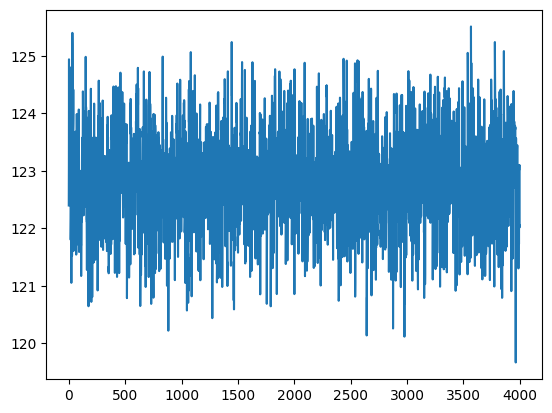

In [6]:
# view diagnostics
fit.draws_pd()['theta'].plot()
details = fit.summary()
details.loc['theta','R_hat']

Mean    122.813
5%      121.478
95%     124.157
Name: theta, dtype: float64

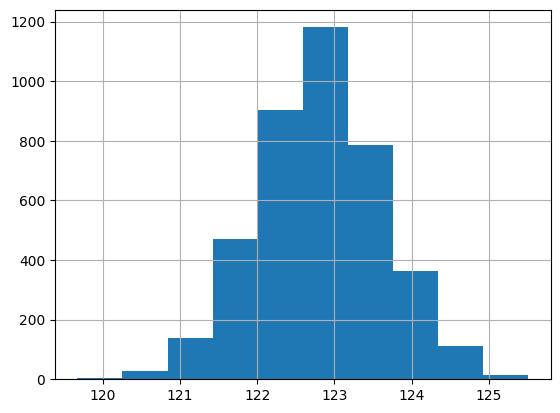

In [7]:
fit.draws_pd()['theta'].hist()
details.loc['theta',['Mean', '5%', '95%']]

4.

Now use `stan` to estimate a slightly reparameterized model. Suppose you want to use a normal prior on an unconstrained parameter. Notice that if something is positive, then the (natural) log of it is unconstrained. Similarly, if something is unconstrained, the exponential of it is positive.

Therefore, use the following model


$$
\theta \sim \text{Normal}(a,b)
$$
and
$$
y_i \mid \theta \sim \text{Poisson}(e^{\theta})
$$

    
Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data)


01:02:06 - cmdstanpy - INFO - compiling stan file /bml24/05/poisson_norm.stan to exe file /bml24/05/poisson_norm
01:02:27 - cmdstanpy - INFO - compiled model executable: /bml24/05/poisson_norm
01:02:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:02:27 - cmdstanpy - INFO - CmdStan done processing.


1.0021

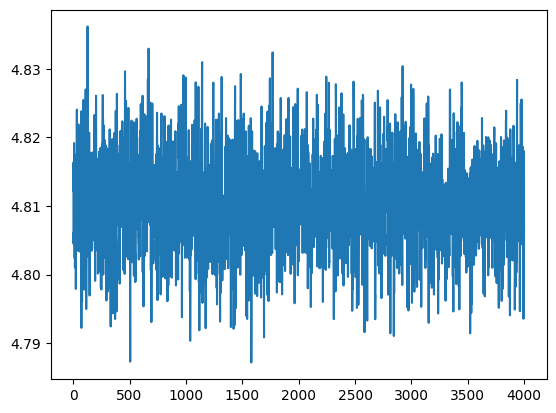

In [8]:
# build model
model_code = os.path.join('.', 'poisson_norm.stan')
model = CmdStanModel(stan_file=model_code)

# run sims
num_samps = 192
normal_data = {'N' : num_samps, 'y': dk}
fit = model.sample(normal_data)

# view diagnostics
fit.draws_pd()['theta'].plot()
details = fit.summary()
details.loc['theta','R_hat']

Mean    4.81060
5%      4.79958
95%     4.82140
Name: theta, dtype: float64

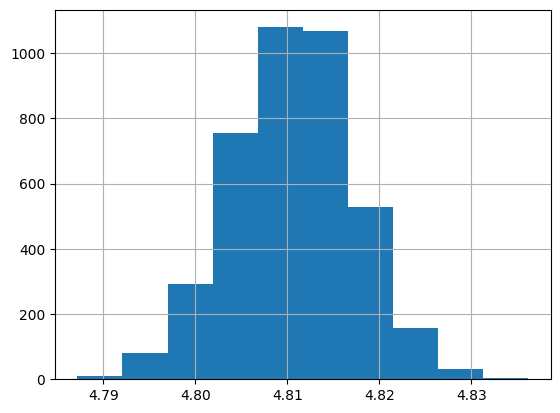

In [9]:
# info on unconstrained theta
fit.draws_pd()['theta'].hist()
details.loc['theta',['Mean', '5%', '95%']]

Mean    122.808
5%      121.459
95%     124.139
Name: exp_theta, dtype: float64

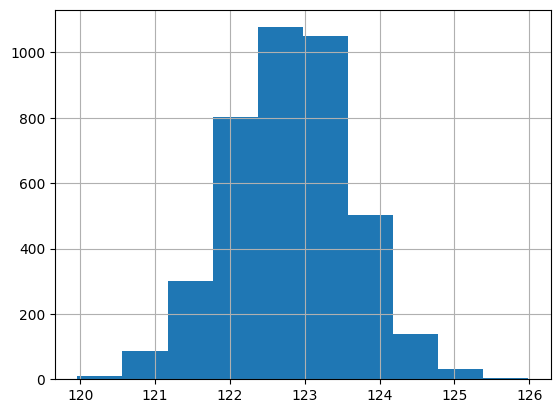

In [10]:
# info on the actual parameter used to simulate data
fit.draws_pd()['exp_theta'].hist()
details.loc['exp_theta',['Mean', '5%', '95%']]

In [11]:
np.exp(4.81051)

122.79422660615958

### Problem 2: Binomial Data (again!)

Suppose that you have $m > 1$ count data points $y_1, \ldots, y_m$, each having a $\text{Binomial}(n,\eta)$ distribution. Assume further that they're all independent.

Here $n$ is the maximum for each data point. $m$ is the number of data points.

In our second homework we used the beta prior for the parameter that was bounded between $0$ and $1$. 

Now, you must use a normal prior for an unconstrained parameter. 

If $0 < \eta < 1$, then the *logit* transformation is a way to make $-\infty < \theta < \infty$ (unconstrained). Alternatively, if you have $\eta$ that's unconstrained, then the `inv_logit` will squash the value to lie between $0$ and $1$.


`stan` conveniently has a `logit()` and an `inv_logit()` function already made for you.



Use `stan` to estimate your model on any fictitious data you would like. Be sure to

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data, again).


In [12]:
some_fake_data = np.random.choice([0, 1], 100, p = [.9, .1])
some_fake_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

01:02:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:02:28 - cmdstanpy - INFO - CmdStan done processing.


1.00397

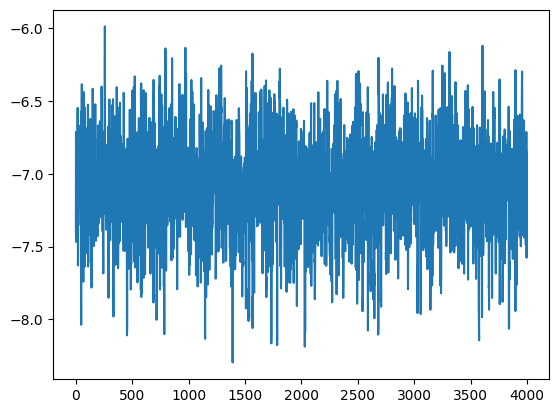

In [13]:
# build model
model_code = os.path.join('.', 'binom_normal.stan')
model = CmdStanModel(stan_file=model_code)

# run sims
num_samps = 100
mu_prior = 0
sigma_prior = 9999
binom_data = {'N' : num_samps,
              'y': some_fake_data,
              'mu_prior' : mu_prior,
              'sigma_prior' : sigma_prior}
fit = model.sample(binom_data)

# view diagnostics
fit.draws_pd()['theta'].plot()
details = fit.summary()
details.loc['theta','R_hat']

Mean   -7.07966
5%     -7.64774
95%    -6.56189
Name: theta, dtype: float64

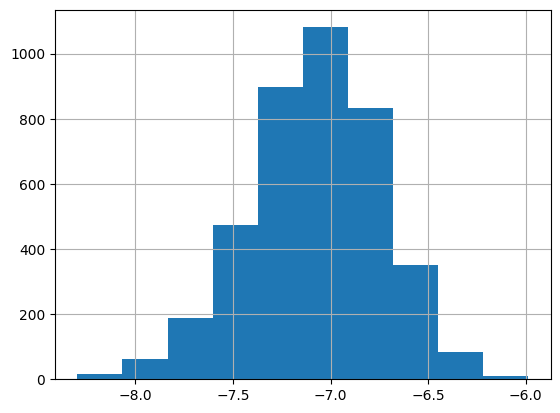

In [14]:
# info on unconstrained theta
fit.draws_pd()['theta'].hist()
details.loc['theta',['Mean', '5%', '95%']]

Mean    0.000888
5%      0.000477
95%     0.001411
Name: nu, dtype: float64

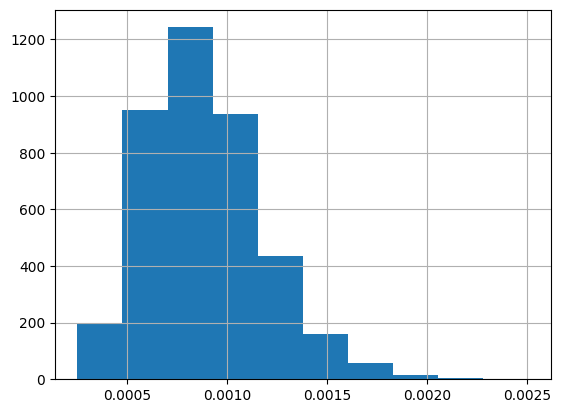

In [15]:
# info on the actual parameter used to simulate data
fit.draws_pd()['eta'].hist()
details.loc['eta',['Mean', '5%', '95%']]

In [16]:
some_fake_data.mean()/len(some_fake_data)

0.0009